# CSX46: Class session 2
## *Introduction to the igraph package and the Pathway Commons network in SIF format*

### Objective: load a network of human molecular interactions and create three igraph `Graph` objects from it (one for protein-protein interactions, one for metabolism interactions, and one for directed protein-protein interactions)

In this notebook we will use the `igraph` package to load molecular interaction data (in edge-list format) into some networks. Documentation about the Python interface to the `igraph` package can be found here: https://igraph.org/python/#docs

We will be loading the molecular interaction data from a data file in Simple Interaction File (SIF) format, that has been previously downloaded for you from the Pathway Commons 2.0 website (https://www.pathwaycommons.org/) and can be found on the JupyterHub server in `shared/pathway_commons.sif`. Here is a sneak peek at the file format:
```
A1BG    controls-expression-of  A2M
A1BG    interacts-with  ABCC6
A1BG    controls-phosphorylation-of     AKT1
A1BG    controls-state-change-of        AKT1
A1BG    interacts-with  ANXA7
A1BG    interacts-with  CDKN1A
A1BG    interacts-with  CRISP3
A1BG    interacts-with  GDPD1
A1BG    in-complex-with GRB2
A1BG    interacts-with  GRB7
```
As you can see, SIF is a three-column tab-delimited data file format. The first and third columns contain names of molecules (in most cases a protein, but in some cases a metabolite or other chemical). The second column contains an interaction type, of which there are 13 (more about that below).

To start with, we are going to need to import the `pandas` and `csv` packages:

In [1]:
import pandas
import csv

OK, we are going to read in the Pathway Commons data in SIF format. Recall that a SIF file is a tab-separated value file. You can find the file as `shared/pathway_commons.sif`. Load it into a data frame `df` using `pandas.read_csv`. Don't forget to specify that the separator is the tab `\t`. Use the `names` argument to name the three columns `species1`, `interaction_type`, and `species2`. Note: for each row, the `interaction_type` column contains one of 11 different interaction types (identified by a string, like `interacts-with` or `controls-production-of`). Specify that no quoting is allowed using `quoting=csv.QUOTE_NONE`. Note: if you are new to `pandas`, you may find it helpful to run `help(pandas.read_csv)`.

In [2]:
df = pandas.read_csv("shared/pathway_commons.sif", 
                     sep="\t", 
                     quoting=csv.QUOTE_NONE,
                     names=["species1","interaction_type","species2"])

Let's take a peek at `df` using the `pandas.core.frame.DataFrame.head` method:

In [3]:
df.head()

,species1,interaction_type,species2
0,A1BG,controls-expression-of,A2M
1,A1BG,interacts-with,ABCC6
2,A1BG,controls-phosphorylation-of,AKT1
3,A1BG,controls-state-change-of,AKT1
4,A1BG,interacts-with,ANXA7


Next, for each of the three types of networks, define a `set` of the relevant interaction types for the given network. We'll abbreviate the three network types as follows: 

- protein-protein interaction network: PPI
- metabolic network: metab
- protein-protein directed interaction network: PPD

Let's assume that the 13 different interaction types map to the three different network types as follows:

- PPI network contains edges of interaction type `interacts-with`, `in-complex-with`, and `neighbor-of`

- metab network contains edges of interaction type `controls-production-of`, `consumption-controlled-by`, and `controls-transport-of-chemical`

- PPD network contains edges of interaction type `catalysis-precedes`, `controls-phosphorylation-of`, `controls-state-change-of`, `controls-transport-of`, and `controls-expression-of`

(note, there are two interaction types, `reacts-with` and `chemical-affects`, that we will not be working with in this notebook).

So, define three `set` objects containing the aforementioned `interaction_type` strings, one for each of the three types of networks:

In [4]:
interaction_types_ppi = {"interacts-with",
                         "in-complex-with",
                         "neighbor-of"}

interaction_types_metab = {"controls-production-of",
                           "consumption-controlled-by",
                           "controls-transport-of-chemical"}

interaction_types_ppd = {"catalysis-precedes",
                         "controls-phosphorylation-of",
                         "controls-state-change-of",
                         "controls-transport-of",
                         "controls-expression-of"}

Now, sub-select rows from `df` for each of the three networks, using the `pandas.core.series.Series.isin` method:

In [5]:
df_ppi = df[df.interaction_type.isin(interaction_types_ppi)]
df_metab = df[df.interaction_type.isin(interaction_types_metab)]
df_ppd = df[df.interaction_type.isin(interaction_types_ppd)]

Now, generate an edge-list representation of each of the three networks, by subsetting to the `species1` and `species2` columns. (Note: this means that the specific interaction type information is being dropped from each of the networks). Then convert to a `numpy.ndarray` by referencing the `.values` member, and then apply the `numpy.ndarray.tolist()` method:

In [6]:
df_ppi_el = df_ppi[["species1","species2"]].values.tolist()
df_metab_el = df_metab[["species1","species2"]].values.tolist()
df_ppd_el = df_ppd[["species1","species2"]].values.tolist()

Take a peek at the edge-list representation for the PPI graph, using list indexing to see the first six entries:

In [7]:
df_ppi_el[0:6]

[['A1BG', 'ABCC6'],
 ['A1BG', 'ANXA7'],
 ['A1BG', 'CDKN1A'],
 ['A1BG', 'CRISP3'],
 ['A1BG', 'GDPD1'],
 ['A1BG', 'GRB2']]

Yup, that's an edge-list. 

Now, import the `igraph` package

In [8]:
import igraph

Make an `igraph.Graph` Graph object for the PPI network, by passing `df_ppi_el` to the `Graph.TupleList()` constructor

In [9]:
graph_ppi = igraph.Graph.TupleList(df_ppi_el)

View a summary of the graph, by passing the graph object to the `summary` function. You may want to consult the R documentation for the `igraph` function `summary` in order to interpret the output of running `summary`:
https://igraph.org/r/doc/print.igraph.html

In [10]:
igraph.summary(graph_ppi)

IGRAPH UN-- 17020 523498 -- 
+ attr: name (v)


How many vertices does the PPI network have?  How many edges? Is it directed or undirected?

Now do the same for the metabolic network, but specifying `directed=True`.

In [11]:
graph_metab = igraph.Graph.TupleList(df_metab_el, directed=True)
igraph.summary(graph_metab)

IGRAPH DN-- 7620 38145 -- 
+ attr: name (v)


Do you see where the `summary` information denotes that it is a directed graph? How many edges are in the metabolic network?

Now, do the same for the directed protein-protein interaction network:

In [12]:
graph_ppd = igraph.Graph.TupleList(df_ppd_el, directed=True)
igraph.summary(graph_ppd)

IGRAPH DN-- 16063 359713 -- 
+ attr: name (v)


Question: of the three networks that you just created, which has the most edges?

Now, let's use igraph to draw a small toy network (not the whole PPI!)

To do this, first we need to import cairo

In [13]:
import cairo

Next, we need to create a small graph. Let's make a three-vertex undirected graph from an edge-list. Let's connect all vertices to all other vertices: 1<->2, 2<->3, 3<->1. We'll once again use `igraph.Graph.TupleList` to do this:


In [14]:
testgraph = igraph.Graph.TupleList([[1,2], [2,3], [3,1]])

Now, let's use the static method `igraph.drawing.plot` to plot `testgraph` (you'll probably want to specify `bbox=[0,0,100,100]` so the graph isn't huge by default):

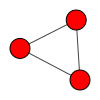

In [15]:
igraph.drawing.plot(testgraph, bbox=[0,0,100,100])